## Color Distribution Data

[INFO] Loading real...
[INFO] Loading gan...
[INFO] Loading diffusion...


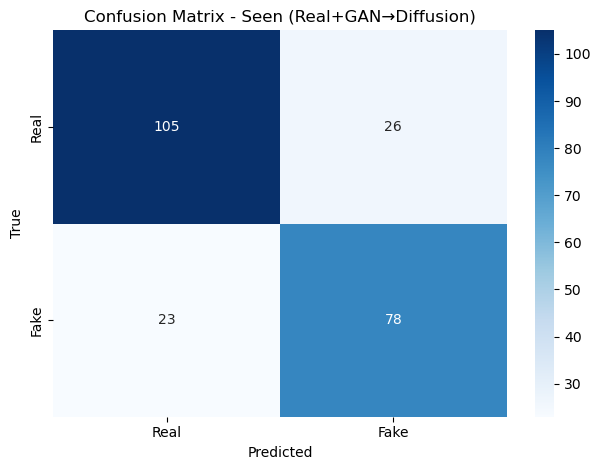

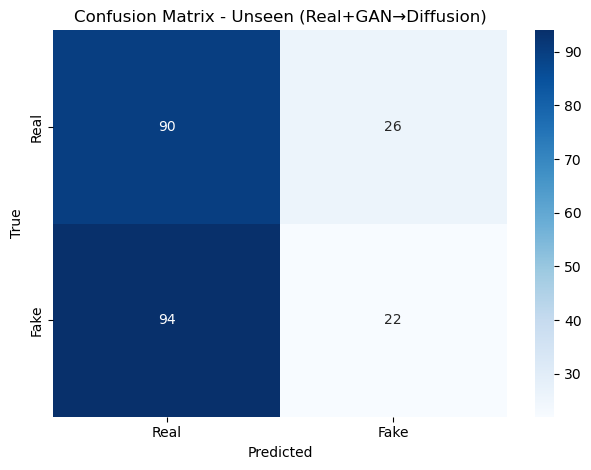

Unseen Accuracy per label (Real+GAN→Diffusion): Real=0.7759, Fake=0.1897


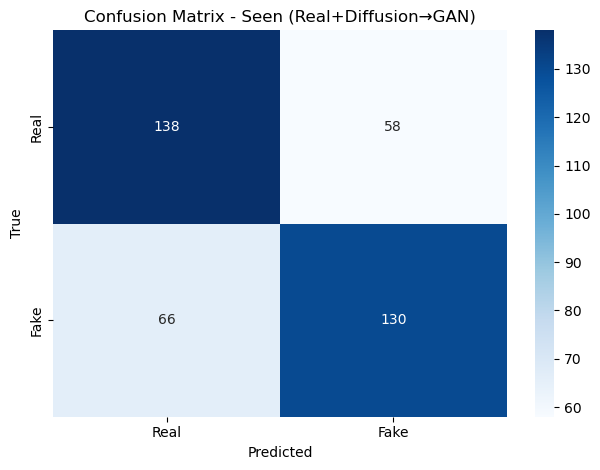

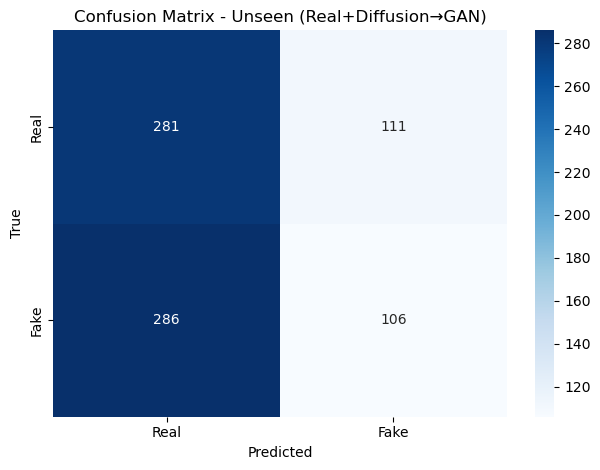

Unseen Accuracy per label (Real+Diffusion→GAN): Real=0.7168, Fake=0.2704

=== Generalization Results (Color Distribution) ===
       Training Setup    Test on  Accuracy (Seen)  Accuracy (Unseen)  G-Score  \
0            Real+GAN  Diffusion           0.7888             0.4828   0.6120   
1      Real+Diffusion        GAN           0.6837             0.4936   0.7220   
2  Real+GAN+Diffusion    Holdout           0.7695             0.7712   1.0023   

   Unseen Real Acc  Unseen Fake Acc  
0           0.7759           0.1897  
1           0.7168           0.2704  
2           0.8025           0.7399  


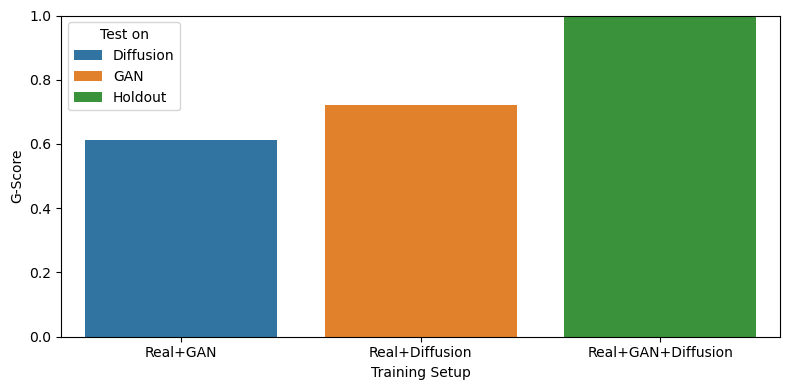

In [14]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix


# ------------------ DATASETS ------------------

DATASETS = {
    'bedroom': {
        'real': "../data/BEST/bedroom/real_200x200",
        'gan': "../data/BEST/bedroom/gansformer",
        'diffusion': "../data/BEST/bedroom/ddpm"
    },
    'face': {
        'real': '../data/BEST/face/real',
        'gan': '../data/BEST/face/stylegan2',
        'diffusion': '../data/BEST/face/palette'
    },
    'imagenet': {
        'real': '/mnt/data/imagenet/real_imagenet',
        'gan': '/mnt/data/imagenet/big_gan',
        'diffusion': '/mnt/data/imagenet/vq_diffusion'
    }
}

# ------------------ FEATURE EXTRACTION ------------------

def extract_color_features(image_path, bins=(16, 16, 16)):
    image = cv2.imread(image_path)
    if image is None:
        return None
    try:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        image_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

        hist_rgb = cv2.calcHist([image_rgb], [0, 1, 2], None, bins, [0, 256]*3).flatten()
        hist_hsv = cv2.calcHist([image_hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256]).flatten()
        hist_ycrcb = cv2.calcHist([image_ycrcb], [1, 2], None, (16, 16), [0, 256, 0, 256]).flatten()

        return np.concatenate([hist_rgb, hist_hsv, hist_ycrcb])
    except:
        return None

def load_color_features_by_class(dataset_dict):
    data = {'real': [], 'gan': [], 'diffusion': []}
    for label, folder in dataset_dict.items():
        print(f"[INFO] Loading {label}...")
        for ext in ('*.jpg', '*.jpeg', '*.png'):
            for path in glob(os.path.join(folder, ext)):
                feat = extract_color_features(path)
                if feat is not None:
                    data[label].append(feat)
    return data

# ---------------- GENERALIZATION EXPERIMENT ----------------

def run_generalization_experiment(data, train_labels, test_label, title_suffix=''):
    # Split real class
    real_data = data['real']
    train_real_all, unseen_real = train_test_split(real_data, test_size=0.15, random_state=42)

    # Other class
    other_class = [lbl for lbl in train_labels if lbl != 'real'][0]
    train_other_all, _ = train_test_split(data[other_class], test_size=0.15, random_state=42)

    # Undersample to equal size
    n_train = min(len(train_real_all), len(train_other_all))
    train_real  = train_real_all[:n_train]
    train_other = train_other_all[:n_train]

    X_train_full = train_real + train_other
    y_train_full = [0]*n_train + [1]*n_train

    # Validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        stratify=y_train_full, test_size=0.3, random_state=42
    )

    # Balance training set
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    # Build unseen test set
    _, unseen_fake = train_test_split(data[test_label], test_size=0.15, random_state=42)
    n_unseen = min(len(unseen_real), len(unseen_fake), len(y_val))
    X_test = unseen_real[:n_unseen] + unseen_fake[:n_unseen]
    y_test = [0]*n_unseen + [1]*n_unseen

    # Train classifier
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    # Predictions
    y_val_pred  = clf.predict(X_val[:2*n_unseen])
    y_test_pred = clf.predict(X_test)

    acc_seen   = accuracy_score(y_val[:2*n_unseen], y_val_pred)
    acc_unseen = accuracy_score(y_test, y_test_pred)
    g_score    = 1 - ((acc_seen - acc_unseen) / (acc_seen + 1e-8))

    # Plot confusion matrices
    def plot_cm(y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
        plt.title(title)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    plot_cm(y_val[:2*n_unseen], y_val_pred,  f"Confusion Matrix - Seen ({title_suffix})")
    plot_cm(y_test,           y_test_pred, f"Confusion Matrix - Unseen ({title_suffix})")

    # Per‐label unseen accuracy
    cm_u = confusion_matrix(y_test, y_test_pred)
    acc_real_unseen = cm_u[0,0]/cm_u[0].sum() if cm_u[0].sum()>0 else 0.0
    acc_fake_unseen = cm_u[1,1]/cm_u[1].sum() if cm_u[1].sum()>0 else 0.0

    print(f"Unseen Accuracy per label ({title_suffix}): "
          f"Real={acc_real_unseen:.4f}, Fake={acc_fake_unseen:.4f}")

    return (
        round(acc_seen, 4),
        round(acc_unseen, 4),
        round(g_score,    4),
        round(acc_real_unseen, 4),
        round(acc_fake_unseen, 4)
    )

# ---------------- PIPELINE RUNNER ----------------
def run_generalization_pipeline(dataset_name='bedroom'):
    data    = load_color_features_by_class(DATASETS[dataset_name])
    results = []

    # 1) Real + GAN → Diffusion
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','gan'], 'diffusion', title_suffix='Real+GAN→Diffusion'
    )
    results.append(['Real+GAN', 'Diffusion', s, u, g, r_acc, f_acc])

    # 2) Real + Diffusion → GAN
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','diffusion'], 'gan', title_suffix='Real+Diffusion→GAN'
    )
    results.append(['Real+Diffusion', 'GAN', s, u, g, r_acc, f_acc])

    # 3) Holdout with all three
    X_all = data['real'] + data['gan'] + data['diffusion']
    y_all = [0]*len(data['real']) + [1]*len(data['gan']) + [1]*len(data['diffusion'])
    X_bal, y_bal = SMOTE(random_state=42).fit_resample(X_all, y_all)

    X_temp, X_test, y_temp, y_test = train_test_split(
        X_bal, y_bal, test_size=0.15, stratify=y_bal, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    seen_acc   = accuracy_score(y_val,     clf.predict(X_val))
    unseen_acc = accuracy_score(y_test,    clf.predict(X_test))
    g_score    = 1 - ((seen_acc - unseen_acc) / (seen_acc + 1e-8))

    cm_h = confusion_matrix(y_test, clf.predict(X_test))
    real_acc = cm_h[0,0]/cm_h[0].sum()
    fake_acc = cm_h[1,1]/cm_h[1].sum()

    results.append([
        'Real+GAN+Diffusion', 'Holdout',
        round(seen_acc,4), round(unseen_acc,4), round(g_score,4),
        round(real_acc,4), round(fake_acc,4)
    ])

    df = pd.DataFrame(
        results,
        columns=[
            "Training Setup","Test on",
            "Accuracy (Seen)","Accuracy (Unseen)","G-Score",
            "Unseen Real Acc","Unseen Fake Acc"
        ]
    )
    print("\n=== Generalization Results (Color Distribution) ===")
    print(df)
    return df

# ---------------- USAGE ----------------
if __name__ == "__main__":
    df = run_generalization_pipeline(dataset_name='bedroom')
    plt.figure(figsize=(8,4))
    sns.barplot(data=df, x="Training Setup", y="G-Score", hue="Test on")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

## Noise Pattern Data

[INFO] Loading real images...


100%|██████████| 5000/5000 [00:32<00:00, 156.20it/s]


  └─ Loaded 5000 features for 'real'
[INFO] Loading gan images...


100%|██████████| 5000/5000 [00:31<00:00, 158.81it/s]


  └─ Loaded 5000 features for 'gan'
[INFO] Loading diffusion images...


100%|██████████| 768/768 [00:04<00:00, 157.81it/s]


  └─ Loaded 768 features for 'diffusion'


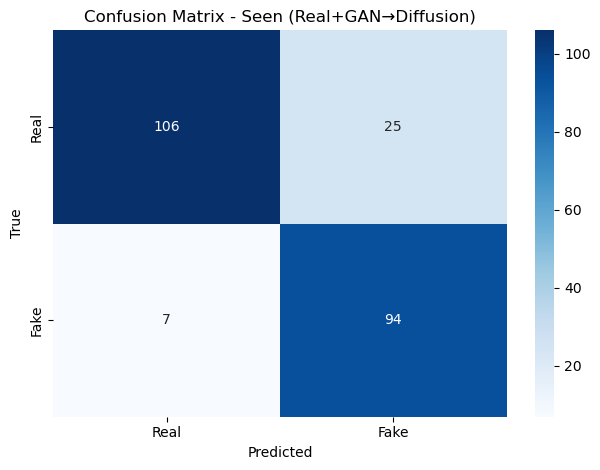

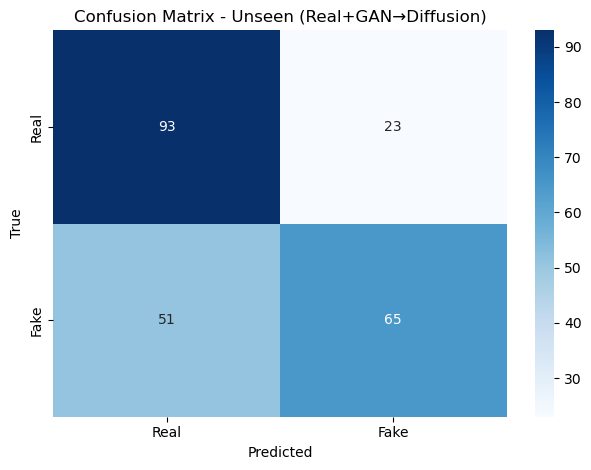

Unseen Accuracy per label (Real+GAN→Diffusion): Real=0.8017, Fake=0.5603


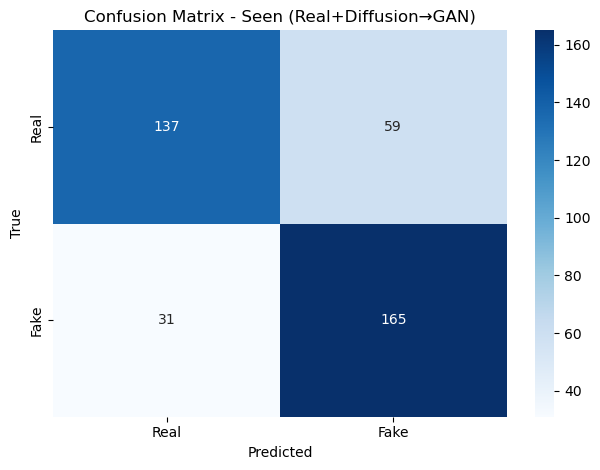

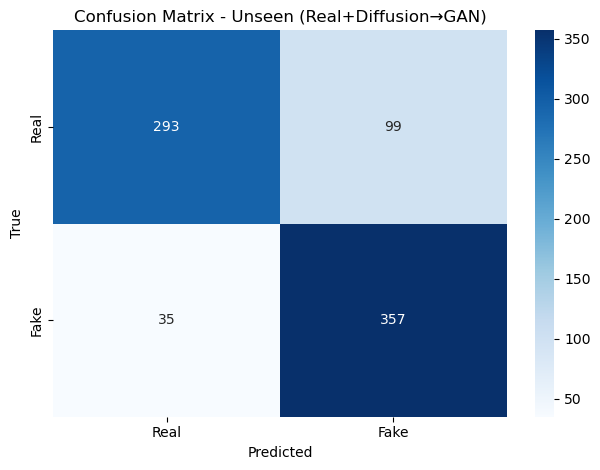

Unseen Accuracy per label (Real+Diffusion→GAN): Real=0.7474, Fake=0.9107

=== Generalization Results (Noise Features) ===
       Training Setup    Test on  Accuracy (Seen)  Accuracy (Unseen)  G-Score  \
0            Real+GAN  Diffusion           0.8621             0.6810   0.7900   
1      Real+Diffusion        GAN           0.7704             0.8291   1.0762   
2  Real+GAN+Diffusion    Holdout           0.8359             0.8504   1.0173   

   Unseen Real Acc  Unseen Fake Acc  
0           0.8017           0.5603  
1           0.7474           0.9107  
2           0.8152           0.8855  


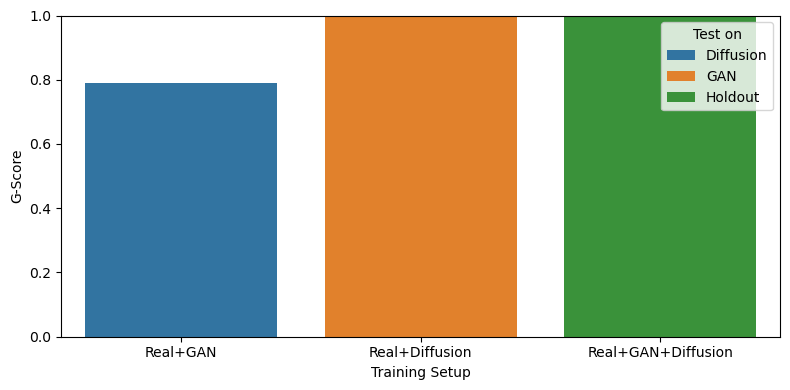

In [15]:
import os
import cv2
import numpy as np
import pywt
from glob import glob
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage.util import view_as_windows
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix

# ---------------- DATASET PATHS ----------------

DATASETS = {
    'bedroom': {
        'real': "../data/BEST/bedroom/real_200x200",
        'gan': "../data/BEST/bedroom/gansformer",
        'diffusion': "../data/BEST/bedroom/ddpm"
    },
    'face': {
        'real': "../data/BEST/face/real",
        'gan': "../data/BEST/face/stylegan2",
        'diffusion': "../data/BEST/face/palette"
    },
    'imagenet': {
        'real': "/mnt/data/imagenet/real_imagenet",
        'gan': "/mnt/data/imagenet/big_gan",
        'diffusion': "/mnt/data/imagenet/vq_diffusion"
    }
}

# ---------------- FEATURE EXTRACTION ----------------

def estimate_local_noise(image, window_size=7):
    padded_img = np.pad(image, pad_width=window_size // 2, mode='reflect')
    windows = view_as_windows(padded_img, (window_size, window_size))
    return np.std(windows, axis=(2, 3))

def extract_wavelet_noise(image, wavelet='db1', level=1):
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    _, (cH, cV, cD) = coeffs
    return np.sqrt(cH**2 + cV**2 + cD**2)

def extract_combined_noise_features(image_path, window_size=7, wavelet='db1'):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = img.astype(np.float32) / 255.0
    try:
        local = estimate_local_noise(img, window_size)
        wavelet_energy = extract_wavelet_noise(img, wavelet)
        hist_local = np.histogram(local.flatten(), bins=64, range=(0, 1), density=True)[0]
        hist_wavelet = np.histogram(wavelet_energy.flatten(), bins=64, range=(0, 1), density=True)[0]
        return np.concatenate([hist_local, hist_wavelet])
    except:
        return None

def load_noise_features_by_class(dataset_dict, method='combined'):
    data = {'real': [], 'gan': [], 'diffusion': []}
    for label, path in dataset_dict.items():
        print(f"[INFO] Loading {label} images...")
        image_paths = []
        for ext in ('*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG'):
            image_paths.extend(glob(os.path.join(path, ext)))
        
        for img_path in tqdm(image_paths):
            feat = extract_combined_noise_features(img_path) if method == 'combined' else None
            if feat is not None:
                data[label].append(feat)
        
        print(f"  └─ Loaded {len(data[label])} features for '{label}'")
    return data

# ---------------- GENERALIZATION EXPERIMENT ----------------

def run_generalization_experiment(data, train_labels, test_label, title_suffix=''):
    # Split real class
    real_data = data['real']
    train_real_all, unseen_real = train_test_split(real_data, test_size=0.15, random_state=42)

    # Other class
    other_class = [lbl for lbl in train_labels if lbl != 'real'][0]
    train_other_all, _ = train_test_split(data[other_class], test_size=0.15, random_state=42)

    # Undersample to equal size
    n_train = min(len(train_real_all), len(train_other_all))
    train_real  = train_real_all[:n_train]
    train_other = train_other_all[:n_train]

    X_train_full = train_real + train_other
    y_train_full = [0]*n_train + [1]*n_train

    # Validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        stratify=y_train_full, test_size=0.3, random_state=42
    )

    # Balance training set
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    # Build unseen test set
    _, unseen_fake = train_test_split(data[test_label], test_size=0.15, random_state=42)
    n_unseen = min(len(unseen_real), len(unseen_fake), len(y_val))
    X_test = unseen_real[:n_unseen] + unseen_fake[:n_unseen]
    y_test = [0]*n_unseen + [1]*n_unseen

    # Train classifier
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    # Predictions
    y_val_pred  = clf.predict(X_val[:2*n_unseen])
    y_test_pred = clf.predict(X_test)

    acc_seen   = accuracy_score(y_val[:2*n_unseen], y_val_pred)
    acc_unseen = accuracy_score(y_test, y_test_pred)
    g_score    = 1 - ((acc_seen - acc_unseen) / (acc_seen + 1e-8))

    # Plot confusion matrices
    def plot_cm(y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
        plt.title(title)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    plot_cm(y_val[:2*n_unseen], y_val_pred,  f"Confusion Matrix - Seen ({title_suffix})")
    plot_cm(y_test,           y_test_pred, f"Confusion Matrix - Unseen ({title_suffix})")

    # Per‐label unseen accuracy
    cm_u = confusion_matrix(y_test, y_test_pred)
    acc_real_unseen = cm_u[0,0]/cm_u[0].sum() if cm_u[0].sum()>0 else 0.0
    acc_fake_unseen = cm_u[1,1]/cm_u[1].sum() if cm_u[1].sum()>0 else 0.0

    print(f"Unseen Accuracy per label ({title_suffix}): "
          f"Real={acc_real_unseen:.4f}, Fake={acc_fake_unseen:.4f}")

    return (
        round(acc_seen, 4),
        round(acc_unseen, 4),
        round(g_score,    4),
        round(acc_real_unseen, 4),
        round(acc_fake_unseen, 4)
    )

# ---------------- PIPELINE RUNNER ----------------
def run_generalization_pipeline(dataset_name='bedroom'):
    data    = load_noise_features_by_class(DATASETS[dataset_name])
    results = []

    # 1) Real + GAN → Diffusion
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','gan'], 'diffusion', title_suffix='Real+GAN→Diffusion'
    )
    results.append(['Real+GAN', 'Diffusion', s, u, g, r_acc, f_acc])

    # 2) Real + Diffusion → GAN
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','diffusion'], 'gan', title_suffix='Real+Diffusion→GAN'
    )
    results.append(['Real+Diffusion', 'GAN', s, u, g, r_acc, f_acc])

    # 3) Holdout with all three
    X_all = data['real'] + data['gan'] + data['diffusion']
    y_all = [0]*len(data['real']) + [1]*len(data['gan']) + [1]*len(data['diffusion'])
    X_bal, y_bal = SMOTE(random_state=42).fit_resample(X_all, y_all)

    X_temp, X_test, y_temp, y_test = train_test_split(
        X_bal, y_bal, test_size=0.15, stratify=y_bal, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    seen_acc   = accuracy_score(y_val,     clf.predict(X_val))
    unseen_acc = accuracy_score(y_test,    clf.predict(X_test))
    g_score    = 1 - ((seen_acc - unseen_acc) / (seen_acc + 1e-8))

    cm_h = confusion_matrix(y_test, clf.predict(X_test))
    real_acc = cm_h[0,0]/cm_h[0].sum()
    fake_acc = cm_h[1,1]/cm_h[1].sum()

    results.append([
        'Real+GAN+Diffusion', 'Holdout',
        round(seen_acc,4), round(unseen_acc,4), round(g_score,4),
        round(real_acc,4), round(fake_acc,4)
    ])

    df = pd.DataFrame(
        results,
        columns=[
            "Training Setup","Test on",
            "Accuracy (Seen)","Accuracy (Unseen)","G-Score",
            "Unseen Real Acc","Unseen Fake Acc"
        ]
    )
    print("\n=== Generalization Results (Noise Features) ===")
    print(df)
    return df

# ---------------- USAGE ----------------
if __name__ == "__main__":
    df = run_generalization_pipeline(dataset_name='bedroom')
    plt.figure(figsize=(8,4))
    sns.barplot(data=df, x="Training Setup", y="G-Score", hue="Test on")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

## Frequency Domain Data

[INFO] Extracting FFT from real


100%|██████████| 5000/5000 [00:04<00:00, 1021.63it/s]


  └─ Loaded 5000 features for 'real'
[INFO] Extracting FFT from gan


100%|██████████| 5000/5000 [00:04<00:00, 1048.27it/s]


  └─ Loaded 5000 features for 'gan'
[INFO] Extracting FFT from diffusion


100%|██████████| 768/768 [00:00<00:00, 1219.03it/s]


  └─ Loaded 768 features for 'diffusion'


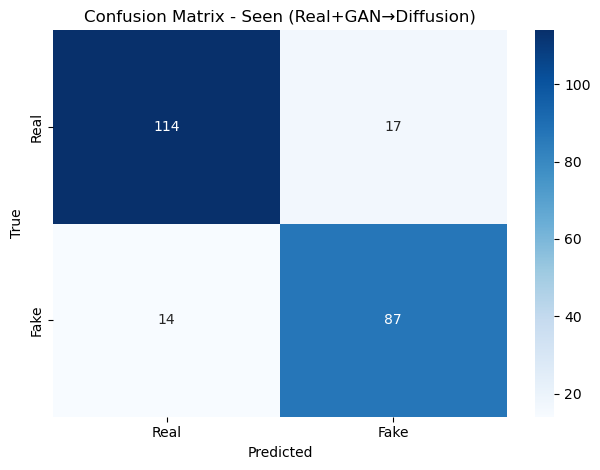

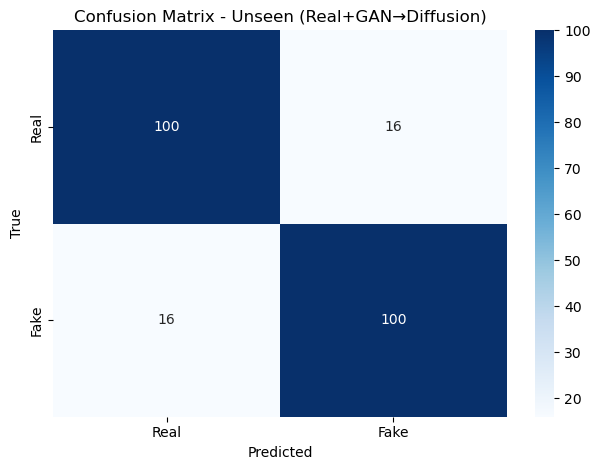

Unseen Accuracy per label (Real+GAN→Diffusion): Real=0.8621, Fake=0.8621


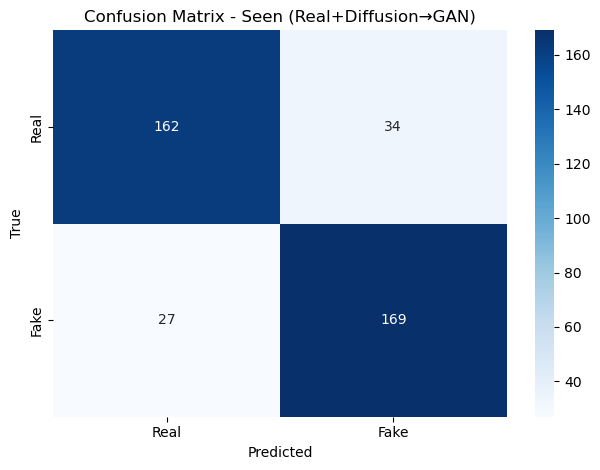

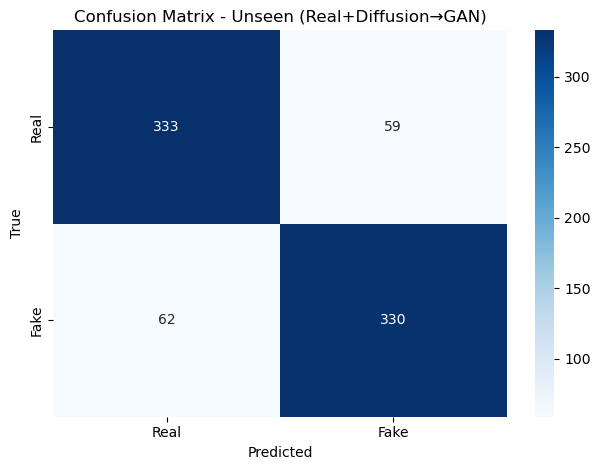

Unseen Accuracy per label (Real+Diffusion→GAN): Real=0.8495, Fake=0.8418

=== Generalization Results (Color Distribution) ===
       Training Setup    Test on  Accuracy (Seen)  Accuracy (Unseen)  G-Score  \
0            Real+GAN  Diffusion           0.8664             0.8621   0.9950   
1      Real+Diffusion        GAN           0.8444             0.8457   1.0015   
2  Real+GAN+Diffusion    Holdout           0.8533             0.8850   1.0372   

   Unseen Real Acc  Unseen Fake Acc  
0           0.8621           0.8621  
1           0.8495           0.8418  
2           0.8811           0.8890  


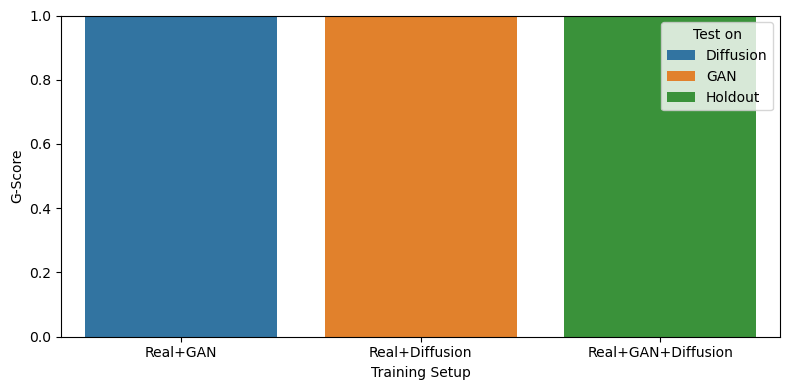

In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from scipy.stats import linregress
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter


# ---------------- DATASET ----------------

DATASETS = {
    'bedroom': {
        'real': "../data/BEST/bedroom/real_200x200",
        'gan': "../data/BEST/bedroom/gansformer",
        'diffusion': "../data/BEST/bedroom/ddpm"
    },
    'face': {
        'real': "../data/BEST/face/real",
        'gan': "../data/BEST/face/stylegan2",
        'diffusion': "../data/BEST/face/palette"
    },
    'imagenet': {
        'real': "../data/BEST/imagenet/real_imagenet",
        'gan': "../data/BEST/imagenet/big_gan",
        'diffusion': "../data/BEST/imagenet/vq_diffusion"
    }
}

# ---------------- FEATURE EXTRACTION ----------------

def compute_fft_features(image, return_profile=False):
    H, W = image.shape
    if np.std(image) < 1e-6:
        return (np.nan, np.nan, None) if return_profile else (np.nan, np.nan)

    f_transform = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f_transform)
    log_magnitude = np.log1p(np.abs(f_shifted))

    y, x = np.indices((H, W))
    center = np.array([H // 2, W // 2])
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2).astype(np.int32)

    radial_sum = np.bincount(r.ravel(), weights=log_magnitude.ravel())
    radial_count = np.bincount(r.ravel())
    radial_profile = radial_sum / (radial_count + 1e-8)

    freqs = np.arange(1, len(radial_profile))
    power = radial_profile[1:]
    mask = power > 0

    if np.sum(mask) < 10:
        return (np.nan, np.nan, radial_profile) if return_profile else (np.nan, np.nan)

    log_freqs = np.log(freqs[mask])
    log_power = np.log(power[mask])
    if np.any(np.isnan(log_power)) or np.any(np.isinf(log_power)):
        return (np.nan, np.nan, radial_profile) if return_profile else (np.nan, np.nan)

    slope, _, _, _, _ = linregress(log_freqs, log_power)
    cutoff = int(0.33 * len(power))
    hf_ratio = np.sum(power[cutoff:]) / (np.sum(power) + 1e-8)
    return (-slope, hf_ratio, radial_profile) if return_profile else (-slope, hf_ratio)

def load_fft_features_by_class(dataset_dict):
    data = {'real': [], 'gan': [], 'diffusion': []}
    for label, folder_path in dataset_dict.items():
        print(f"[INFO] Extracting FFT from {label}")
        image_paths = []
        for ext in ('*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG'):
            image_paths.extend(glob(os.path.join(folder_path, ext)))
        for file_path in tqdm(image_paths):
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = img.astype(np.float32) / 255.0
            slope, hf_ratio, _ = compute_fft_features(img, return_profile=True)
            if not np.isnan(slope) and not np.isnan(hf_ratio):
                data[label].append([slope, hf_ratio])
        print(f"  └─ Loaded {len(data[label])} features for '{label}'")
    return data

# ---------------- UTILS ----------------

def compute_per_class_accuracies(y_true, y_pred):
    labels = np.unique(y_true)
    accs = {}
    for label in labels:
        mask = np.array(y_true) == label
        accs[f"Acc Label {label}"] = round(accuracy_score(np.array(y_true)[mask], np.array(y_pred)[mask]), 4)
    return accs

# ---------------- GENERALIZATION EXPERIMENT ----------------

def run_generalization_experiment(data, train_labels, test_label, title_suffix=''):
    # Split real class
    real_data = data['real']
    train_real_all, unseen_real = train_test_split(real_data, test_size=0.15, random_state=42)

    # Other class
    other_class = [lbl for lbl in train_labels if lbl != 'real'][0]
    train_other_all, _ = train_test_split(data[other_class], test_size=0.15, random_state=42)

    # Undersample to equal size
    n_train = min(len(train_real_all), len(train_other_all))
    train_real  = train_real_all[:n_train]
    train_other = train_other_all[:n_train]

    X_train_full = train_real + train_other
    y_train_full = [0]*n_train + [1]*n_train

    # Validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        stratify=y_train_full, test_size=0.3, random_state=42
    )

    # Balance training set
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    # Build unseen test set
    _, unseen_fake = train_test_split(data[test_label], test_size=0.15, random_state=42)
    n_unseen = min(len(unseen_real), len(unseen_fake), len(y_val))
    X_test = unseen_real[:n_unseen] + unseen_fake[:n_unseen]
    y_test = [0]*n_unseen + [1]*n_unseen

    # Train classifier
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    # Predictions
    y_val_pred  = clf.predict(X_val[:2*n_unseen])
    y_test_pred = clf.predict(X_test)

    acc_seen   = accuracy_score(y_val[:2*n_unseen], y_val_pred)
    acc_unseen = accuracy_score(y_test, y_test_pred)
    g_score    = 1 - ((acc_seen - acc_unseen) / (acc_seen + 1e-8))

    # Plot confusion matrices
    def plot_cm(y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
        plt.title(title)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    plot_cm(y_val[:2*n_unseen], y_val_pred,  f"Confusion Matrix - Seen ({title_suffix})")
    plot_cm(y_test,           y_test_pred, f"Confusion Matrix - Unseen ({title_suffix})")

    # Per‐label unseen accuracy
    cm_u = confusion_matrix(y_test, y_test_pred)
    acc_real_unseen = cm_u[0,0]/cm_u[0].sum() if cm_u[0].sum()>0 else 0.0
    acc_fake_unseen = cm_u[1,1]/cm_u[1].sum() if cm_u[1].sum()>0 else 0.0

    print(f"Unseen Accuracy per label ({title_suffix}): "
          f"Real={acc_real_unseen:.4f}, Fake={acc_fake_unseen:.4f}")

    return (
        round(acc_seen, 4),
        round(acc_unseen, 4),
        round(g_score,    4),
        round(acc_real_unseen, 4),
        round(acc_fake_unseen, 4)
    )

# ---------------- PIPELINE RUNNER ----------------
def run_generalization_pipeline(dataset_name='bedroom'):
    data    = load_fft_features_by_class(DATASETS[dataset_name])
    results = []

    # 1) Real + GAN → Diffusion
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','gan'], 'diffusion', title_suffix='Real+GAN→Diffusion'
    )
    results.append(['Real+GAN', 'Diffusion', s, u, g, r_acc, f_acc])

    # 2) Real + Diffusion → GAN
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','diffusion'], 'gan', title_suffix='Real+Diffusion→GAN'
    )
    results.append(['Real+Diffusion', 'GAN', s, u, g, r_acc, f_acc])

    # 3) Holdout with all three
    X_all = data['real'] + data['gan'] + data['diffusion']
    y_all = [0]*len(data['real']) + [1]*len(data['gan']) + [1]*len(data['diffusion'])
    X_bal, y_bal = SMOTE(random_state=42).fit_resample(X_all, y_all)

    X_temp, X_test, y_temp, y_test = train_test_split(
        X_bal, y_bal, test_size=0.15, stratify=y_bal, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    seen_acc   = accuracy_score(y_val,     clf.predict(X_val))
    unseen_acc = accuracy_score(y_test,    clf.predict(X_test))
    g_score    = 1 - ((seen_acc - unseen_acc) / (seen_acc + 1e-8))

    cm_h = confusion_matrix(y_test, clf.predict(X_test))
    real_acc = cm_h[0,0]/cm_h[0].sum()
    fake_acc = cm_h[1,1]/cm_h[1].sum()

    results.append([
        'Real+GAN+Diffusion', 'Holdout',
        round(seen_acc,4), round(unseen_acc,4), round(g_score,4),
        round(real_acc,4), round(fake_acc,4)
    ])

    df = pd.DataFrame(
        results,
        columns=[
            "Training Setup","Test on",
            "Accuracy (Seen)","Accuracy (Unseen)","G-Score",
            "Unseen Real Acc","Unseen Fake Acc"
        ]
    )
    print("\n=== Generalization Results (Color Distribution) ===")
    print(df)
    return df

# ---------------- USAGE ----------------
if __name__ == "__main__":
    df = run_generalization_pipeline(dataset_name='bedroom')
    plt.figure(figsize=(8,4))
    sns.barplot(data=df, x="Training Setup", y="G-Score", hue="Test on")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

## Texture & Structure Data

[INFO] Extracting real features


100%|██████████| 5000/5000 [01:49<00:00, 45.48it/s]


  └─ Loaded 5000 features for 'real'
[INFO] Extracting gan features


100%|██████████| 5000/5000 [01:48<00:00, 45.96it/s]


  └─ Loaded 5000 features for 'gan'
[INFO] Extracting diffusion features


100%|██████████| 768/768 [00:16<00:00, 46.04it/s]


  └─ Loaded 768 features for 'diffusion'


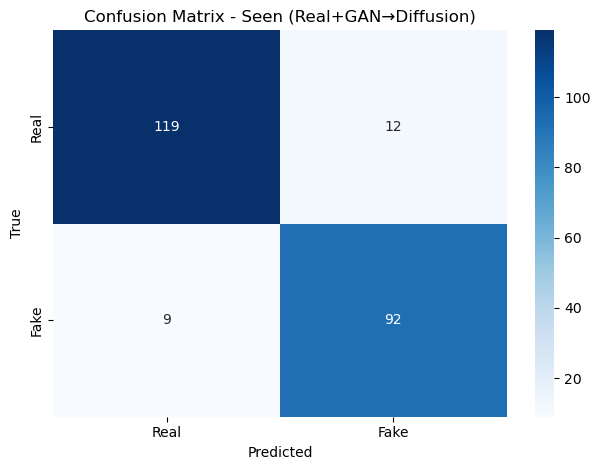

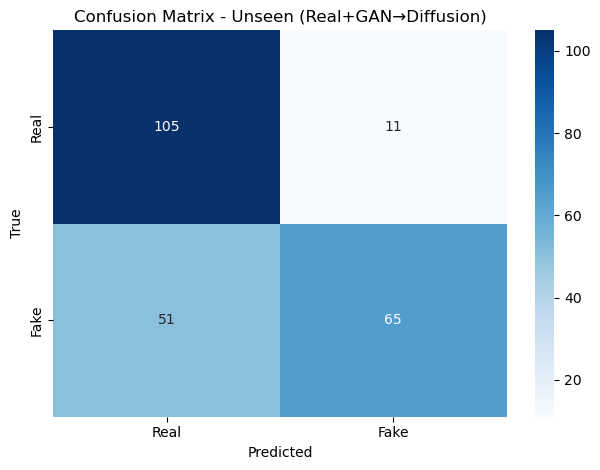

Unseen Accuracy per label (Real+GAN→Diffusion): Real=0.9052, Fake=0.5603


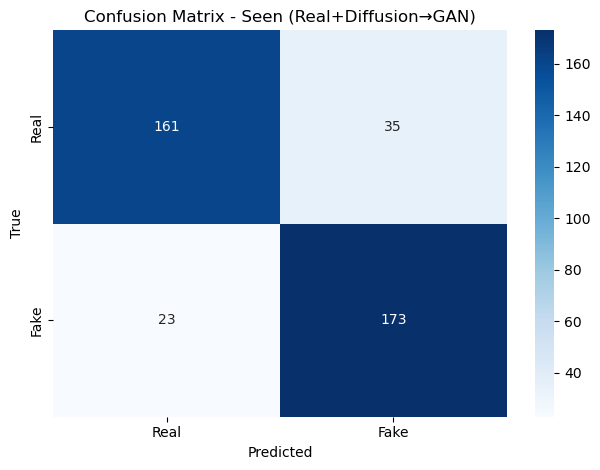

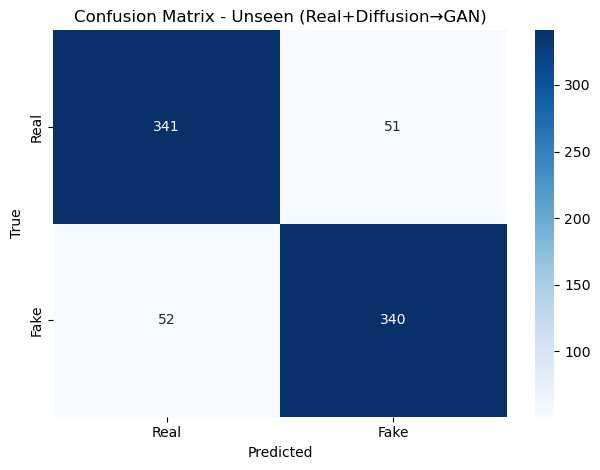

Unseen Accuracy per label (Real+Diffusion→GAN): Real=0.8699, Fake=0.8673

=== Generalization Results (Color Distribution) ===
       Training Setup    Test on  Accuracy (Seen)  Accuracy (Unseen)  G-Score  \
0            Real+GAN  Diffusion           0.9095             0.7328   0.8057   
1      Real+Diffusion        GAN           0.8520             0.8686   1.0195   
2  Real+GAN+Diffusion    Holdout           0.9076             0.9237   1.0178   

   Unseen Real Acc  Unseen Fake Acc  
0           0.9052           0.5603  
1           0.8699           0.8673  
2           0.9238           0.9237  


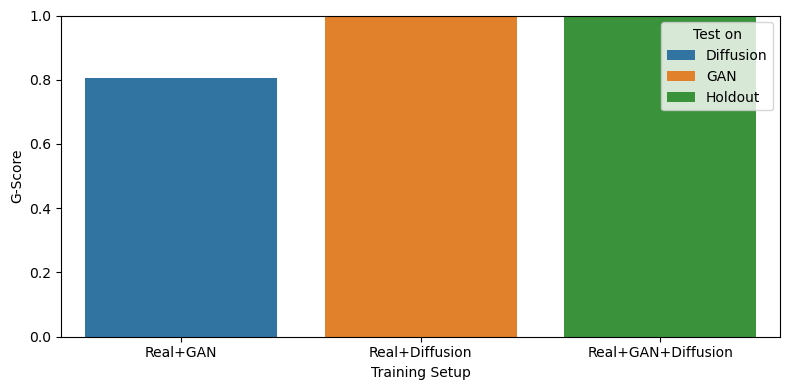

In [17]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from PIL import Image
import torch
from torchvision import models, transforms
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

# ---------------- DEVICE & VGG SETUP ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:9].to(device)
vgg.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

@torch.no_grad()
def extract_vgg_features(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        feat_map = vgg(x).squeeze(0).cpu()
        return feat_map.mean(dim=(1, 2)).numpy()
    except:
        return None

def extract_lbp_glcm_features(image, radius=1, n_points=8):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    props = ['contrast', 'homogeneity', 'energy', 'correlation']
    glcm_feats = [graycoprops(glcm, p)[0, 0] for p in props]
    return np.concatenate([lbp_hist, glcm_feats])

# ---------------- DATASET ----------------

DATASETS = {
    'bedroom': {
        'real': "../data/BEST/bedroom/real_200x200",
        'gan': "../data/BEST/bedroom/gansformer",
        'diffusion': "../data/BEST/bedroom/ddpm"
    },
    'face': {
        'real': "../data/BEST/face/real",
        'gan': "../data/BEST/face/stylegan2",
        'diffusion': "../data/BEST/face/palette"
    },
    'imagenet': {
        'real': "/mnt/data/imagenet/real_imagenet",
        'gan': "/mnt/data/imagenet/big_gan",
        'diffusion': "/mnt/data/imagenet/vq_diffusion"
    }
}

# ---------------- LOAD FEATURES ----------------

def load_texture_structure_by_class(dataset_dict):
    data = {'real': [], 'gan': [], 'diffusion': []}
    for label, folder in dataset_dict.items():
        print(f"[INFO] Extracting {label} features")
        image_paths = []
        for ext in ('*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG'):
            image_paths.extend(glob(os.path.join(folder, ext)))

        for path in tqdm(image_paths):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = img.astype(np.float32) / 255.0
            feat_lbp = extract_lbp_glcm_features(img)
            feat_vgg = extract_vgg_features(path)
            if feat_vgg is None:
                continue
            data[label].append(np.concatenate([feat_lbp, feat_vgg]))

        print(f"  └─ Loaded {len(data[label])} features for '{label}'")
    return data

# ---------------- GENERALIZATION EXPERIMENT ----------------

def run_generalization_experiment(data, train_labels, test_label, title_suffix=''):
    # Split real class
    real_data = data['real']
    train_real_all, unseen_real = train_test_split(real_data, test_size=0.15, random_state=42)

    # Other class
    other_class = [lbl for lbl in train_labels if lbl != 'real'][0]
    train_other_all, _ = train_test_split(data[other_class], test_size=0.15, random_state=42)

    # Undersample to equal size
    n_train = min(len(train_real_all), len(train_other_all))
    train_real  = train_real_all[:n_train]
    train_other = train_other_all[:n_train]

    X_train_full = train_real + train_other
    y_train_full = [0]*n_train + [1]*n_train

    # Validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        stratify=y_train_full, test_size=0.3, random_state=42
    )

    # Balance training set
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    # Build unseen test set
    _, unseen_fake = train_test_split(data[test_label], test_size=0.15, random_state=42)
    n_unseen = min(len(unseen_real), len(unseen_fake), len(y_val))
    X_test = unseen_real[:n_unseen] + unseen_fake[:n_unseen]
    y_test = [0]*n_unseen + [1]*n_unseen

    # Train classifier
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    # Predictions
    y_val_pred  = clf.predict(X_val[:2*n_unseen])
    y_test_pred = clf.predict(X_test)

    acc_seen   = accuracy_score(y_val[:2*n_unseen], y_val_pred)
    acc_unseen = accuracy_score(y_test, y_test_pred)
    g_score    = 1 - ((acc_seen - acc_unseen) / (acc_seen + 1e-8))

    # Plot confusion matrices
    def plot_cm(y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
        plt.title(title)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    plot_cm(y_val[:2*n_unseen], y_val_pred,  f"Confusion Matrix - Seen ({title_suffix})")
    plot_cm(y_test,           y_test_pred, f"Confusion Matrix - Unseen ({title_suffix})")

    # Per‐label unseen accuracy
    cm_u = confusion_matrix(y_test, y_test_pred)
    acc_real_unseen = cm_u[0,0]/cm_u[0].sum() if cm_u[0].sum()>0 else 0.0
    acc_fake_unseen = cm_u[1,1]/cm_u[1].sum() if cm_u[1].sum()>0 else 0.0

    print(f"Unseen Accuracy per label ({title_suffix}): "
          f"Real={acc_real_unseen:.4f}, Fake={acc_fake_unseen:.4f}")

    return (
        round(acc_seen, 4),
        round(acc_unseen, 4),
        round(g_score,    4),
        round(acc_real_unseen, 4),
        round(acc_fake_unseen, 4)
    )

# ---------------- PIPELINE RUNNER ----------------
def run_generalization_pipeline(dataset_name='bedroom'):
    data    = load_texture_structure_by_class(DATASETS[dataset_name])
    results = []

    # 1) Real + GAN → Diffusion
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','gan'], 'diffusion', title_suffix='Real+GAN→Diffusion'
    )
    results.append(['Real+GAN', 'Diffusion', s, u, g, r_acc, f_acc])

    # 2) Real + Diffusion → GAN
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','diffusion'], 'gan', title_suffix='Real+Diffusion→GAN'
    )
    results.append(['Real+Diffusion', 'GAN', s, u, g, r_acc, f_acc])

    # 3) Holdout with all three
    X_all = data['real'] + data['gan'] + data['diffusion']
    y_all = [0]*len(data['real']) + [1]*len(data['gan']) + [1]*len(data['diffusion'])
    X_bal, y_bal = SMOTE(random_state=42).fit_resample(X_all, y_all)

    X_temp, X_test, y_temp, y_test = train_test_split(
        X_bal, y_bal, test_size=0.15, stratify=y_bal, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    seen_acc   = accuracy_score(y_val,     clf.predict(X_val))
    unseen_acc = accuracy_score(y_test,    clf.predict(X_test))
    g_score    = 1 - ((seen_acc - unseen_acc) / (seen_acc + 1e-8))

    cm_h = confusion_matrix(y_test, clf.predict(X_test))
    real_acc = cm_h[0,0]/cm_h[0].sum()
    fake_acc = cm_h[1,1]/cm_h[1].sum()

    results.append([
        'Real+GAN+Diffusion', 'Holdout',
        round(seen_acc,4), round(unseen_acc,4), round(g_score,4),
        round(real_acc,4), round(fake_acc,4)
    ])

    df = pd.DataFrame(
        results,
        columns=[
            "Training Setup","Test on",
            "Accuracy (Seen)","Accuracy (Unseen)","G-Score",
            "Unseen Real Acc","Unseen Fake Acc"
        ]
    )
    print("\n=== Generalization Results (Color Distribution) ===")
    print(df)
    return df

# ---------------- USAGE ----------------
if __name__ == "__main__":
    df = run_generalization_pipeline(dataset_name='bedroom')
    plt.figure(figsize=(8,4))
    sns.barplot(data=df, x="Training Setup", y="G-Score", hue="Test on")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()